Выбор пал на следующий датасет https://www.kaggle.com/andrewmvd/heart-failure-clinical-data. По самому заданию необходимо прогнозировать вероятность смерти при определенных биохимических и индивидуальных показателях человека. Для начала просто посмотрим взаимосвязь показателей и оценим влияет ли какой-то из них значимо на риск наступления смерти.  
Для начала испортируем необходимые библиотеки и загрузим датасет

In [1]:
import numpy as np
import pandas as pd

In [2]:
pd.options.display.float_format = "{:,.2f}".format

In [3]:
df = pd.read_csv("heart_failure_clinical_records_dataset.csv")

In [4]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.00,0,582,0,20,1,"265,000.00",1.90,130,1,0,4,1
1,55.00,0,7861,0,38,0,"263,358.03",1.10,136,1,0,6,1
2,65.00,0,146,0,20,0,"162,000.00",1.30,129,1,1,7,1
3,50.00,1,111,0,20,0,"210,000.00",1.90,137,1,0,7,1
4,65.00,1,160,1,20,0,"327,000.00",2.70,116,0,0,8,1


По всем фичам есть небольшая аналитическая выкладка на самом кагле, вставлю ее сюда, чтобы было более понятно по конкретным фичам  
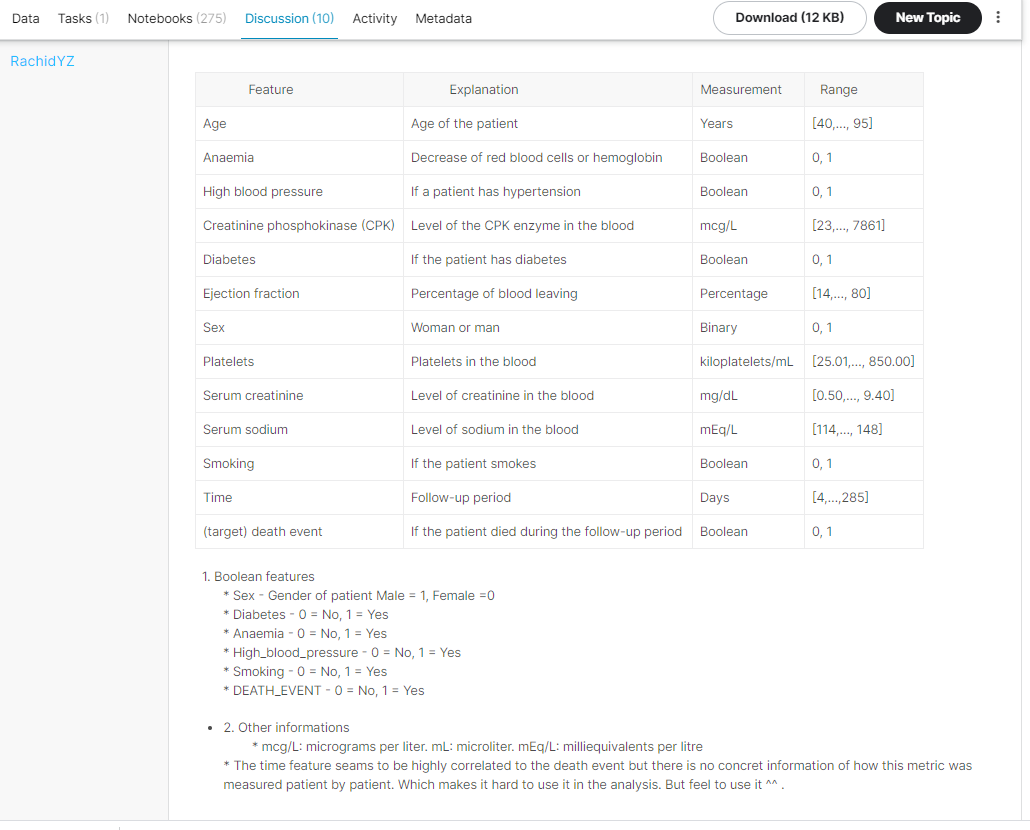  
Я тоже не понимаю что объясняет переменная time поэтому от греха подальше удалю ее

In [5]:
df.drop(columns=["time"], inplace=True)

Посмотрим на описательные статистики и посмотрим есть ли пропущенные значения в датасете

In [6]:
for col in df.columns:
    print(f"{sum(df[col].isna())} NaNs in {col}")

0 NaNs in age
0 NaNs in anaemia
0 NaNs in creatinine_phosphokinase
0 NaNs in diabetes
0 NaNs in ejection_fraction
0 NaNs in high_blood_pressure
0 NaNs in platelets
0 NaNs in serum_creatinine
0 NaNs in serum_sodium
0 NaNs in sex
0 NaNs in smoking
0 NaNs in DEATH_EVENT


Отлично, пропущенных значений нет, посмотрим на описательные статистики непрерывных переменных

In [7]:
df.loc[:, ["age", "creatinine_phosphokinase", "ejection_fraction", "platelets", "serum_creatinine", "serum_sodium"]].describe()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium
count,299.00,299.00,299.00,299.00,299.00,299.00
mean,60.83,581.84,38.08,"263,358.03",1.39,136.63
std,11.89,970.29,11.83,"97,804.24",1.03,4.41
min,40.00,23.00,14.00,"25,100.00",0.50,113.00
25%,51.00,116.50,30.00,"212,500.00",0.90,134.00
50%,60.00,250.00,38.00,"262,000.00",1.10,137.00
75%,70.00,582.00,45.00,"303,500.00",1.40,140.00
max,95.00,"7,861.00",80.00,"850,000.00",9.40,148.00


Если смотреть на распределения, то в принципе по описательным статистикам можно предположить что переменные age, ejection_fraction, platelets, serum_creatinine, serum_sodium имеют более менее нормальное распределение, поскольку данные по средним значениям не очень сильно отличаются от данных по медиане.  
Попробуем использовать тест Шапиро-Вилка чтобы оценить нормальность распределений. Уровень значимости возьмем на уровне 5%. Нулевая гипотеза гласит о том, что данные распределены нормально

In [8]:
from scipy import stats

In [9]:
for col in ["age", "creatinine_phosphokinase", "ejection_fraction", "platelets", "serum_creatinine", "serum_sodium"]:
    print(f"p-value for {col} is {stats.shapiro(df[col].to_numpy())[1]}")

p-value for age is 5.3505704272538424e-05
p-value for creatinine_phosphokinase is 7.050336006853421e-28
p-value for ejection_fraction is 7.215433139862171e-09
p-value for platelets is 2.8837446753443574e-12
p-value for serum_creatinine is 5.3927583038658e-27
p-value for serum_sodium is 9.210247564617191e-10


Ну в целом как видно, все тесты имеют р-значение намного ниже 5%, соответсвенно мы должны отклонить нулевую гипотезу о нормальности распределения наших данных. В связи с этим для дальнейшего анализа непрерывных данных необходимо использовать непараметрические методы оценки взаимосвязи.  
Пока для начала сделаем следующее...построим графики распределения непрервных параметров где по оси абсцис будут параметры 
["creatinine_phosphokinase", "ejection_fraction", "platelets", "serum_creatinine", "serum_sodium"], по оси ординат только "age" при этом точки поделим по признаку DEATH_EVENT

In [10]:
import matplotlib.pyplot as plt
from pylab import rcParams
from mpl_toolkits.mplot3d import Axes3D
plt.style.use("fivethirtyeight")

#%matplotlib inline
%config InlineBackend.figure_format = "svg"
rcParams["figure.figsize"] = 5, 3

Text(0.5, 1.0, 'serum_sodium vs age')

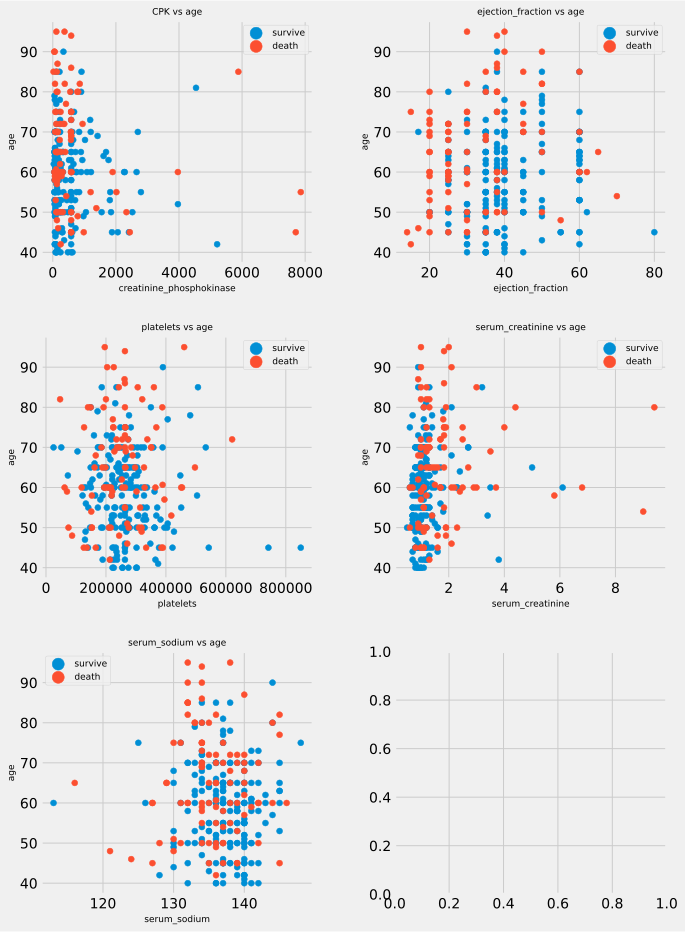

In [11]:
fig, ax = plt.subplots(nrows=3, ncols=2)
ax1, ax2, ax3, ax4, ax5, ax6 = ax.flatten()
fig.set_size_inches(10, 15)
fig.subplots_adjust(wspace=0.3, hspace=0.3)

ax1.scatter(df.loc[df["DEATH_EVENT"] == 0, "creatinine_phosphokinase"].to_numpy(),
            df.loc[df["DEATH_EVENT"] == 0, "age"].to_numpy(), label="survive")
ax1.scatter(df.loc[df["DEATH_EVENT"] == 1, "creatinine_phosphokinase"].to_numpy(),
            df.loc[df["DEATH_EVENT"] == 1, "age"].to_numpy(), label="death")
ax1.legend(fontsize=9, markerscale=2)
ax1.set_xlabel("creatinine_phosphokinase", fontsize=9)
ax1.set_ylabel("age", fontsize=9)
ax1.set_title("CPK vs age", fontsize=9)


ax2.scatter(df.loc[df["DEATH_EVENT"] == 0, "ejection_fraction"].to_numpy(),
            df.loc[df["DEATH_EVENT"] == 0, "age"].to_numpy(), label="survive")
ax2.scatter(df.loc[df["DEATH_EVENT"] == 1, "ejection_fraction"].to_numpy(),
            df.loc[df["DEATH_EVENT"] == 1, "age"].to_numpy(), label="death")
ax2.legend(fontsize=9, markerscale=2)
ax2.set_xlabel("ejection_fraction", fontsize=9)
ax2.set_ylabel("age", fontsize=9)
ax2.set_title("ejection_fraction vs age", fontsize=9)


ax3.scatter(df.loc[df["DEATH_EVENT"] == 0, "platelets"].to_numpy(),
            df.loc[df["DEATH_EVENT"] == 0, "age"].to_numpy(), label="survive")
ax3.scatter(df.loc[df["DEATH_EVENT"] == 1, "platelets"].to_numpy(),
            df.loc[df["DEATH_EVENT"] == 1, "age"].to_numpy(), label="death")
ax3.legend(fontsize=9, markerscale=2)
ax3.set_xlabel("platelets", fontsize=9)
ax3.set_ylabel("age", fontsize=9)
ax3.set_title("platelets vs age", fontsize=9)


ax4.scatter(df.loc[df["DEATH_EVENT"] == 0, "serum_creatinine"].to_numpy(),
            df.loc[df["DEATH_EVENT"] == 0, "age"].to_numpy(), label="survive")
ax4.scatter(df.loc[df["DEATH_EVENT"] == 1, "serum_creatinine"].to_numpy(),
            df.loc[df["DEATH_EVENT"] == 1, "age"].to_numpy(), label="death")
ax4.legend(fontsize=9, markerscale=2)
ax4.set_xlabel("serum_creatinine", fontsize=9)
ax4.set_ylabel("age", fontsize=9)
ax4.set_title("serum_creatinine vs age", fontsize=9)


ax5.scatter(df.loc[df["DEATH_EVENT"] == 0, "serum_sodium"].to_numpy(),
            df.loc[df["DEATH_EVENT"] == 0, "age"].to_numpy(), label="survive")
ax5.scatter(df.loc[df["DEATH_EVENT"] == 1, "serum_sodium"].to_numpy(),
            df.loc[df["DEATH_EVENT"] == 1, "age"].to_numpy(), label="death")
ax5.legend(fontsize=9, markerscale=2)
ax5.set_xlabel("serum_sodium", fontsize=9)
ax5.set_ylabel("age", fontsize=9)
ax5.set_title("serum_sodium vs age", fontsize=9)

Как видим особых существенных однознычных выводов по графикам сделать нельзя. В графике "CPK vs age" нельзя однозначно сказать влияет ли уровень CPK на смертность, хотя по биофизическим параметрам уровень по уровню CPK можно определять наличие инфаркта 
https://ru.wikipedia.org/wiki/%D0%9A%D1%80%D0%B5%D0%B0%D1%82%D0%B8%D0%BD%D0%BA%D0%B8%D0%BD%D0%B0%D0%B7%D0%B0  
По графику "ejection_fraction vs age" видно что ejection_fraction меньше для случаев со смертями, при этом однозначного соответсвия между возрастом и ejection_fraction нет, следовательно ejection_fraction имеет какое-то влияение на событие наступления смерти. ejection_fraction - это процент крови, который покидает сердце после каждого сокращения, другими словами логическое объяснение соответсвует наблюдениям, однако этот показатель не зависит от возраста
остальные показаатели так же распределены примерно равномерно между возрастными группами и при этом нет каких-то зависимостей между показателями смертности и непрерывными переменными.  
  
Итак мы выдвинули гипотезу о том, что уровни наблюдаемых показателей не отличаются в выборках по смертям и выживаниям. Поскольку как мы выяснили наши непрерывные данные распределены не нормально, то использовать т-критерий смысла нет, надо использовать непараметрические методы оценки двух выборок. Попробуем использовать для этого критерий Манна-Уитни.

Поскольку в наших данных преобладают наблюдения по выжываниям

In [12]:
df["DEATH_EVENT"].value_counts()

0    203
1     96
Name: DEATH_EVENT, dtype: int64

Критерий Манна-Уитни в ходе своей работы объединяет две выборки одного признака, далее сортирует их, присваеивает ранги, далее смотрит на определенную сумму рангов и исходя из этого делает определенные выводы. В литературе написано, что критерий должен работать на выборках не более 60....из-за ограниченности табличных значений, в модуле stats об этом ничего не сказано, поэтому ограничение применять не буду. Насколько я понял из литературы, распределение критерия при больших обхемах выборки стремиться к нормальному.  
Для оценки теста нам нужно сравнивать две выборки, одинакового размера желательно, поэтому проведем определенное цикличное тестирование. Поскольку наблюдений по смертям меньше, по дефолту будем брать полный срез по смертям и такое же количество наблюдений по выжившим, посчитаем критерий и посмотрим снова, предварительно перемешав выборку по выжившим. 

In [13]:
def estimate_mann(feature_name, iterations):
    df_death = df.loc[df["DEATH_EVENT"] == 1, feature_name].to_numpy() 
    for i in range(iterations):
        df_survive = df.loc[df["DEATH_EVENT"] == 0, feature_name].sample(n=96, axis=0).to_numpy()
        test = stats.mannwhitneyu(df_death, df_survive)
        print(f"U-test for {feature_name} = {test[1]}")

In [14]:
estimate_mann("creatinine_phosphokinase", 10)

U-test for creatinine_phosphokinase = 0.2635271253810309
U-test for creatinine_phosphokinase = 0.40888775762830093
U-test for creatinine_phosphokinase = 0.21149274989753292
U-test for creatinine_phosphokinase = 0.4159999991708433
U-test for creatinine_phosphokinase = 0.40441455624353007
U-test for creatinine_phosphokinase = 0.10265041474573378
U-test for creatinine_phosphokinase = 0.35090151053491553
U-test for creatinine_phosphokinase = 0.31877445356070233
U-test for creatinine_phosphokinase = 0.3852491720067323
U-test for creatinine_phosphokinase = 0.43027980896853013


Как видно почти все тесты дают очень высокое значение. При использовании критерия Манна-Уитни нулевая гипотеза определяется тем, что различия между выборками незначительны. Таким образом исходя из наших данных мы не можем опровергнуть нулевую гипотезу и следовательно различия между выборками незначительны и следовательно показатель уровня CPK не влияет статистически значимо на распредление смертей и выживаний.....по крайней мере на этих данных.  
  
Проведем такие же исследования для остальных непрерывных данных

In [15]:
estimate_mann("ejection_fraction", 10)

U-test for ejection_fraction = 1.7576124473515267e-07
U-test for ejection_fraction = 2.715949547628351e-06
U-test for ejection_fraction = 1.0691412594564904e-05
U-test for ejection_fraction = 0.00032716919855699077
U-test for ejection_fraction = 4.5085754459772644e-05
U-test for ejection_fraction = 8.098060502672478e-05
U-test for ejection_fraction = 2.4418975618935886e-06
U-test for ejection_fraction = 8.685351771981941e-05
U-test for ejection_fraction = 3.849722909130476e-06
U-test for ejection_fraction = 1.8120078360616674e-05


А в этом случае мы уже получаем другую картину, получается что показатель ejection_fraction имеет статистические различия для наблюдений о выживаниях и смертях. Посмотрим на другие непрерывные показатели.

In [16]:
estimate_mann("platelets", 10)

U-test for platelets = 0.11476436122345518
U-test for platelets = 0.12007227728137848
U-test for platelets = 0.19384122940069093
U-test for platelets = 0.315363985379813
U-test for platelets = 0.05148809207382462
U-test for platelets = 0.46841647023367583
U-test for platelets = 0.4617104044317294
U-test for platelets = 0.05719816167195821
U-test for platelets = 0.06691398636763542
U-test for platelets = 0.23744287044169238


In [17]:
estimate_mann("serum_creatinine", 10)

U-test for serum_creatinine = 7.157528753629362e-08
U-test for serum_creatinine = 1.2192520007184718e-09
U-test for serum_creatinine = 5.967300212763864e-10
U-test for serum_creatinine = 5.968743467138385e-13
U-test for serum_creatinine = 1.0371705660582652e-08
U-test for serum_creatinine = 1.4187328248178014e-07
U-test for serum_creatinine = 1.88092588114897e-07
U-test for serum_creatinine = 1.3924398700235362e-07
U-test for serum_creatinine = 2.2216938698401234e-08
U-test for serum_creatinine = 1.007552799063594e-08


In [18]:
estimate_mann("serum_sodium", 10)

U-test for serum_sodium = 0.001377738450192772
U-test for serum_sodium = 9.005422981109565e-05
U-test for serum_sodium = 0.006498097274252567
U-test for serum_sodium = 0.00018313506829249721
U-test for serum_sodium = 0.03342269906811698
U-test for serum_sodium = 0.0020576005780999903
U-test for serum_sodium = 0.0009132704293228271
U-test for serum_sodium = 0.003817723231945061
U-test for serum_sodium = 0.0006181585818908618
U-test for serum_sodium = 0.0006286199982202153


Исходя из результатов теста, пока можно определить, что статистически значимые различия между событиями смерти и выживания имеют показатели по ejection_fraction, serum_creatinine и serum_sodium. Взглянем поближе на эти данные. Для начала проанализируем ejection_fraction, построим гистограмму

(array([ 23.,  36.,  34., 126.,  20.,  21.,  34.,   3.,   1.,   1.]),
 array([14. , 20.6, 27.2, 33.8, 40.4, 47. , 53.6, 60.2, 66.8, 73.4, 80. ]),
 <BarContainer object of 10 artists>)

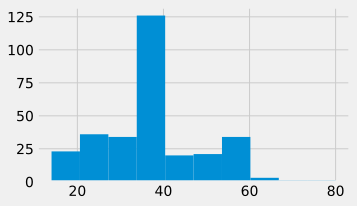

In [19]:
plt.hist(df.loc[:, "ejection_fraction"].to_numpy(), bins=10)

Видно что распределение унимодально, и имеет ярковыраженну моду. В качестве задачи нам нужно все таки доказать что среднее по смертям и выживщим фичи ejection_fraction разное, для этого надо воспользоваться критерием Стьюдента, но для его использования необходимо чтобы данные имели нормальное распределение
Для начала попробуем нормализовать данные, для этого воспользуемся нормированием через натуральный логарифм

(array([ 3.,  2., 18., 36., 34., 89., 57., 24., 34.,  2.]),
 array([2.63905733, 2.81335426, 2.98765119, 3.16194812, 3.33624505,
        3.51054198, 3.68483891, 3.85913584, 4.03343277, 4.2077297 ,
        4.38202663]),
 <BarContainer object of 10 artists>)

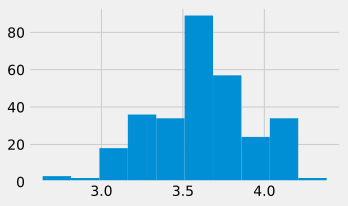

In [20]:
plt.hist(np.log(df.loc[:, "ejection_fraction"].to_numpy()), bins=10)

Нормирование особо ситуацию не исправляет, посмотрим на гистограмму распредлеений по наблюдениям смерти и выживания

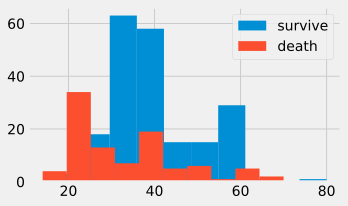

In [21]:
plt.hist(df.loc[df["DEATH_EVENT"] == 0, "ejection_fraction"].to_numpy(), bins=10, label="survive")
plt.hist(df.loc[df["DEATH_EVENT"] == 1, "ejection_fraction"].to_numpy(), bins=10, label="death")
plt.legend()

По графику видно, что моды данных различаются, и у случаев со смертями ejection_fraction в основном ниже чем у случаев выживания. Посмотрим на гисторгаммы других показателей

(125.0, 149.75)

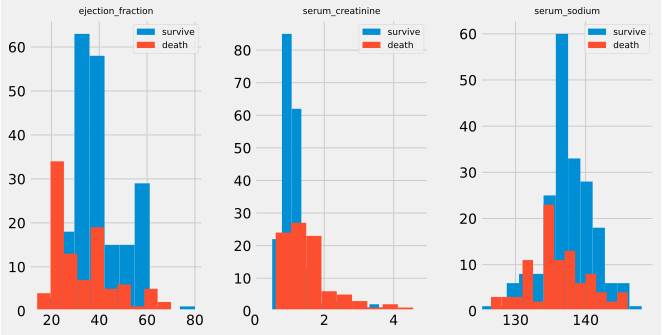

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=3)
ax1, ax2, ax3 = ax.flatten()
fig.set_size_inches(10, 5)
fig.subplots_adjust(wspace=0.3, hspace=0.3)

ax1.hist(df.loc[df["DEATH_EVENT"] == 0, "ejection_fraction"].to_numpy(), bins=10, label="survive")
ax1.hist(df.loc[df["DEATH_EVENT"] == 1, "ejection_fraction"].to_numpy(), bins=10, label="death")
ax1.legend(fontsize=9)
ax1.set_title("ejection_fraction", fontsize=9)

ax2.hist(df.loc[df["DEATH_EVENT"] == 0, "serum_creatinine"].to_numpy(), bins=20, label="survive")
ax2.hist(df.loc[df["DEATH_EVENT"] == 1, "serum_creatinine"].to_numpy(), bins=20, label="death")
ax2.legend(fontsize=9)
ax2.set_title("serum_creatinine", fontsize=9)
ax2.set_xlim((0, 5))

ax3.hist(df.loc[df["DEATH_EVENT"] == 0, "serum_sodium"].to_numpy(), bins=20, label="survive")
ax3.hist(df.loc[df["DEATH_EVENT"] == 1, "serum_sodium"].to_numpy(), bins=20, label="death")
ax3.legend(fontsize=9)
ax3.set_title("serum_sodium", fontsize=9)
ax3.set_xlim(125)

Как видим в основном визуальные различия есть только у показателя ejection_fraction, распределения других показателей визуально не раличаются, меньшая градачия шкалы со смертями обуславливается меньшим количеством наблюдений в датасете. Чтобы как-то определить наличие или отсутствие взаимосвязи в данных мы могли бы провести дисперсионный анализ для переменных, но если разбивать градации по фактору смерть/выживание, это будет недостаточно для аналализа который требует не менее 3 градаций. Поэтому применим Критерий Краскела — Уоллиса, который является аналогом дисперсионного анализа и так же является непараметрическим тестом.

In [23]:
stats.kruskal(df.loc[df["DEATH_EVENT"] == 1, "ejection_fraction"].to_numpy(), 
              df.loc[df["DEATH_EVENT"] == 0, "ejection_fraction"].sample(n=96, axis=0).to_numpy())

KruskalResult(statistic=17.708944984318865, pvalue=2.5741329333626023e-05)

Итак, нулевая гипотеза теста, то что медианы двух выборок одинаковы. В данном случае видно что нулевую гипотезу можно спокойно отклонить и сказать что показатель ejection_fraction статистически значимо отличается в наблюдениях смерти и выживания.  
Проведем аналогичные тесты для остальных трех показателей.

In [24]:
stats.kruskal(df.loc[df["DEATH_EVENT"] == 1, "serum_creatinine"].to_numpy(), 
              df.loc[df["DEATH_EVENT"] == 0, "serum_creatinine"].sample(n=96, axis=0).to_numpy())

KruskalResult(statistic=19.19276800810096, pvalue=1.181601946369704e-05)

In [25]:
stats.kruskal(df.loc[df["DEATH_EVENT"] == 1, "serum_sodium"].to_numpy(), 
              df.loc[df["DEATH_EVENT"] == 0, "serum_sodium"].sample(n=96, axis=0).to_numpy())

KruskalResult(statistic=8.839030489646293, pvalue=0.0029485573829138825)

Ну собственно тест показал тоже самое что и тест Манна-Уитни, а значит наши показатели статистически значино различаются для смерти и выживания. Далее попробуем проанализировать взаимосвязь показателей, для этого для начала построим матрицу коррелиций пирсона для всех непрерывных переменных.

In [26]:
np.corrcoef(np.array([df["creatinine_phosphokinase"].to_numpy(), df["ejection_fraction"].to_numpy(), 
            df["platelets"].to_numpy(), df["serum_creatinine"].to_numpy(), df["serum_sodium"].to_numpy()]))

array([[ 1.        , -0.04407955,  0.02446339, -0.01640848,  0.05955016],
       [-0.04407955,  1.        ,  0.07217747, -0.01130247,  0.17590228],
       [ 0.02446339,  0.07217747,  1.        , -0.04119808,  0.06212462],
       [-0.01640848, -0.01130247, -0.04119808,  1.        , -0.18909521],
       [ 0.05955016,  0.17590228,  0.06212462, -0.18909521,  1.        ]])

В целом видно, что какой-то взаимосвязи в показателях нет. Поэтому для прогнозирования необходимо использовать все количественные показатели, которые имеют статистически значимые взаимосвязи с уровнем смертности.

Далее проанализируем бинарные показатели, которые имеются в наличии anaemia, diabetes, high_blood_pressure, sex, smoking.  
Посмотрим на гистограммы их распределений

Text(0.5, 1.0, 'smoking')

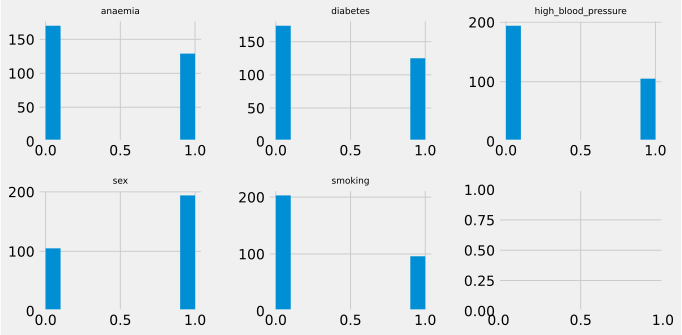

In [27]:
fig, ax = plt.subplots(nrows=2, ncols=3)
ax1, ax2, ax3, ax4, ax5, ax6 = ax.flatten()
fig.set_size_inches(10, 5)
fig.subplots_adjust(wspace=0.4, hspace=0.4)

ax1.hist(df["anaemia"].to_numpy())
ax1.set_title("anaemia", fontsize=9)

ax2.hist(df["diabetes"].to_numpy())
ax2.set_title("diabetes", fontsize=9)

ax3.hist(df["high_blood_pressure"].to_numpy())
ax3.set_title("high_blood_pressure", fontsize=9)

ax4.hist(df["sex"].to_numpy())
ax4.set_title("sex", fontsize=9)

ax5.hist(df["smoking"].to_numpy())
ax5.set_title("smoking", fontsize=9)

В целом пока можно сказать, что данные не разряжены и какие-то выводы по ним построить в принципе возможно. Построим гистограммы для каждого набора данных в разрезе смертей и выживаний, только вместо количества по оси у будет плотность, тогда будет проще сравнивать два графика

Text(0.5, 1.0, 'anaemia vs survive')

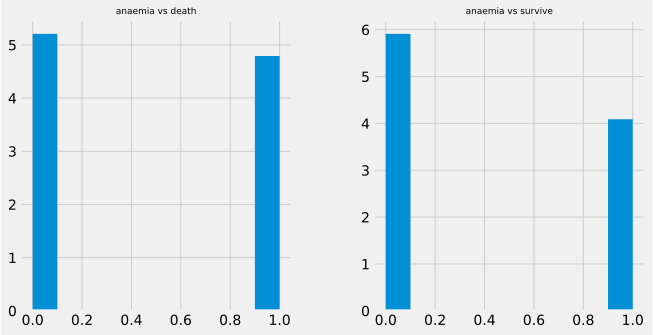

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax1, ax2 = ax.flatten()
fig.set_size_inches(10, 5)
fig.subplots_adjust(wspace=0.3, hspace=0.3)

ax1.hist(df.loc[df["DEATH_EVENT"] == 1, "anaemia"].to_numpy(), density=True)
ax1.set_title("anaemia vs death", fontsize=9)

ax2.hist(df.loc[df["DEATH_EVENT"] == 0, "anaemia"].to_numpy(), density=True)
ax2.set_title("anaemia vs survive", fontsize=9)

По распределению анемии можно визуально пока оценить что ее наличие не существенным образом влияет на показатель смертности, поскольку смерть наступает почти равноодинаково что с наличием анемии что без ее наличия.

Text(0.5, 1.0, 'diabetes vs survive')

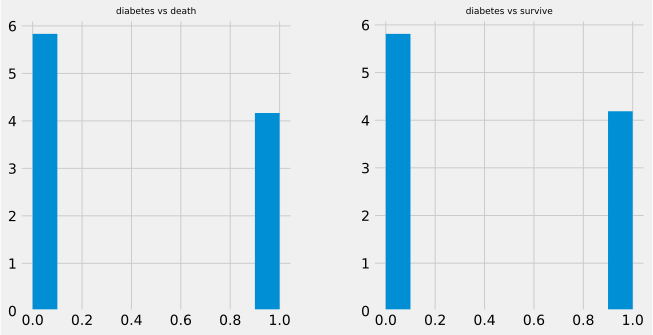

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax1, ax2 = ax.flatten()
fig.set_size_inches(10, 5)
fig.subplots_adjust(wspace=0.3, hspace=0.3)

ax1.hist(df.loc[df["DEATH_EVENT"] == 1, "diabetes"].to_numpy(), density=True)
ax1.set_title("diabetes vs death", fontsize=9)

ax2.hist(df.loc[df["DEATH_EVENT"] == 0, "diabetes"].to_numpy(), density=True)
ax2.set_title("diabetes vs survive", fontsize=9)

С диабетом ситуация равнозначная, наличие диабета как-то существенно не влияет на уровень смертности

Text(0.5, 1.0, 'high_blood_pressure vs survive')

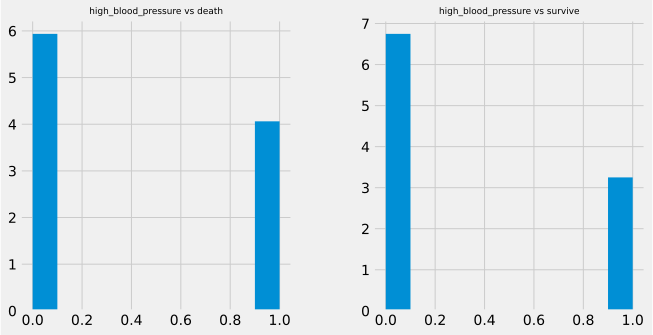

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax1, ax2 = ax.flatten()
fig.set_size_inches(10, 5)
fig.subplots_adjust(wspace=0.3, hspace=0.3)

ax1.hist(df.loc[df["DEATH_EVENT"] == 1, "high_blood_pressure"].to_numpy(), density=True)
ax1.set_title("high_blood_pressure vs death", fontsize=9)

ax2.hist(df.loc[df["DEATH_EVENT"] == 0, "high_blood_pressure"].to_numpy(), density=True)
ax2.set_title("high_blood_pressure vs survive", fontsize=9)

Text(0.5, 1.0, 'sex vs survive')

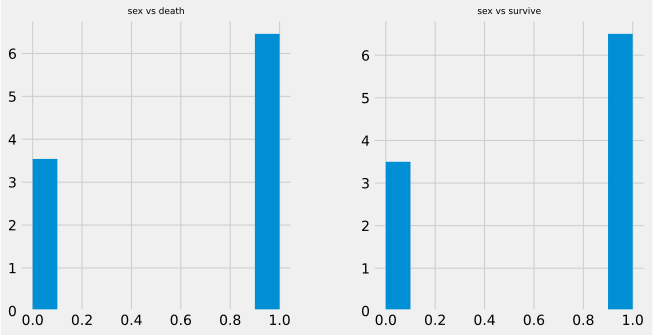

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax1, ax2 = ax.flatten()
fig.set_size_inches(10, 5)
fig.subplots_adjust(wspace=0.3, hspace=0.3)

ax1.hist(df.loc[df["DEATH_EVENT"] == 1, "sex"].to_numpy(), density=True)
ax1.set_title("sex vs death", fontsize=9)

ax2.hist(df.loc[df["DEATH_EVENT"] == 0, "sex"].to_numpy(), density=True)
ax2.set_title("sex vs survive", fontsize=9)

Text(0.5, 1.0, 'smoking vs survive')

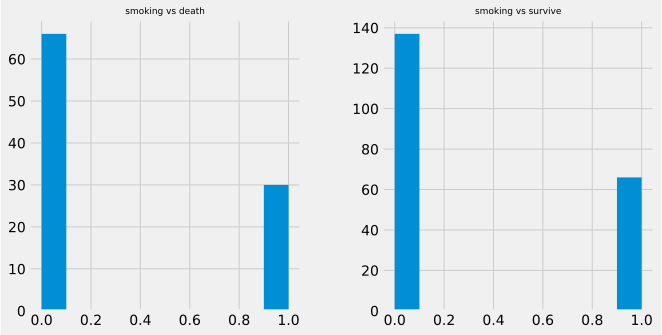

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax1, ax2 = ax.flatten()
fig.set_size_inches(10, 5)
fig.subplots_adjust(wspace=0.3, hspace=0.3)

ax1.hist(df.loc[df["DEATH_EVENT"] == 1, "smoking"].to_numpy())
ax1.set_title("smoking vs death", fontsize=9)

ax2.hist(df.loc[df["DEATH_EVENT"] == 0, "smoking"].to_numpy())
ax2.set_title("smoking vs survive", fontsize=9)

Есть предположение, что подобный распределение частот неслучайно и датасет составлен таким образом, что уровень распределения бинарных признаков имел максимально похожий уровень что в случаях со смертями что в случаях с выживанием. Посмотрим на распределение смерти еще по возрастам....

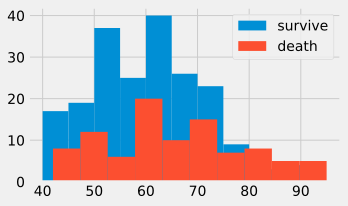

In [33]:
plt.hist(df.loc[df["DEATH_EVENT"] == 0, "age"].to_numpy(), bins=10, label="survive")
plt.hist(df.loc[df["DEATH_EVENT"] == 1, "age"].to_numpy(), bins=10, label="death")
plt.legend()

Распределение смертей по возрастам подозрительно равномерно, по идее с увеличением возраста вероятность смерти должна повышаться, но тут немного другие показатели, судя по всему, данный набор был сделан специально настолько равномерным, чтобы оценить какие-то количественные показатели....как мне кажется. Во-первых распределение бинарных признаков абсолютно одинаковое что при случаях смерти, что при случаях выживания, а во вторых распределение смертей по возврастам. Чтобы оценить распределение бинарных признаков и посмотреть различаются ли они статистически значимы впринципе проведем анализ таблиц сопряженности. Для этого создадим функцию, которая будет анализировать бинарные данные.

In [66]:
def analyse_binom(feature, alpha):
    table = np.array([[df.loc[df["DEATH_EVENT"] == 0, feature].value_counts()[0],
                       df.loc[df["DEATH_EVENT"] == 0, feature].value_counts()[1]], 
                      [df.loc[df["DEATH_EVENT"] == 1, feature].value_counts()[0],
                       df.loc[df["DEATH_EVENT"] == 1, feature].value_counts()[1]]])
    expected_table = np.array([[(table[0][0] + table[0][1]) * (table[0][0] + table[1][0]) / np.sum(table),
                                (table[0][1] + table[0][0]) * (table[0][1] + table[1][1]) / np.sum(table)],
                               [(table[1][0] + table[1][1]) * (table[1][0] + table[0][0]) / np.sum(table),
                                (table[1][1] + table[0][1]) * (table[1][1] + table[1][0]) / np.sum(table)]])
    
    chi_2 = np.sum(((table - expected_table) ** 2) / expected_table)
    return chi_2, f"chi-2 statistic for alpha {stats.chi(df=1).ppf(1 - alpha)}"

In [67]:
analyse_binom("anaemia", 0.05)

(1.3131260590309375, 'chi-2 statistic for alpha 1.9599639845400538')

Статистика не выходит в критическую область, в таком случае принимается нулевая гипотеза о том, что на распрееление уровня смертей показатели анемии не влияют....либо данные собраны таким образом.  
Посмотрим статистику хи квадрат для других бинарных показателей.

In [68]:
analyse_binom("diabetes", 0.05)

(0.0011286639110658035, 'chi-2 statistic for alpha 1.9599639845400538')

In [69]:
analyse_binom("high_blood_pressure", 0.05)

(1.8826805166609848, 'chi-2 statistic for alpha 1.9599639845400538')

In [70]:
analyse_binom("sex", 0.05)

(0.005570700255454755, 'chi-2 statistic for alpha 1.9599639845400538')

In [71]:
analyse_binom("smoking", 0.05)

(0.04764385131281983, 'chi-2 statistic for alpha 1.9599639845400538')

Как видно во всех случаях мы можем отвергнуть нулевую гипотезу о том что есть статистичски значимые различия между бинарными показателями и распределениями смерти. Другими словами в наших данных показатели наличия анемии, диабета, высокого давления, пола и пристрастия к курению распределены одинаково что в условиях наличия события смерти, что в условиях его отсутсвия. 

Исходя их всех полученных данных можно сделать вывод о том, что значимо различаются только показатели ejection_fraction, serum_creatinine, serum_sodium. Попробуем на их основе построить модель предсказания вероятности наступления смерти

In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [76]:
death_event = LogisticRegression(random_state=42, C=0.9, n_jobs=-1)

In [78]:
X_train, X_test, Y_train, Y_test = train_test_split(df.loc[: , ["ejection_fraction", "serum_creatinine", "serum_sodium"]],
                                                    df["DEATH_EVENT"]
                                                    , test_size=0.3, random_state=42)

In [82]:
death_event.fit(X_train, Y_train)

LogisticRegression(C=0.9, n_jobs=-1, random_state=42)

In [88]:
predictions = death_event.predict(X_test)

In [91]:
roc_auc_score(predictions, Y_test)

0.6372180451127819

В итоге получили классификатор с предсказательной силой 63%. Ради интереса посмотрим что будет если строить предсказания по всем фичам

In [96]:
death_event_2 = LogisticRegression(random_state=42, C=0.9, n_jobs=-1)
X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(df.loc[: , :"smoking"],
                                                            df["DEATH_EVENT"], 
                                                            test_size=0.3, random_state=42)

In [97]:
death_event.fit(X_train_2, Y_train_2)

LogisticRegression(C=0.9, n_jobs=-1, random_state=42)

In [98]:
predictions_2 = death_event.predict(X_test_2)
roc_auc_score(predictions_2, Y_test_2)

0.7092907092907093

По итогу получается что мы снизили предсказательную способность модели, выкинув факторы, которые видимо оказалить значимы